In [1]:
# 1. Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
from pathlib import Path

print(f"Numpy version: {np.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"TensorFlow version: {tf.__version__}")


2025-02-12 13:49:00.329503: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Numpy version: 1.26.4
Sklearn version: 1.5.2
TensorFlow version: 2.16.2


In [2]:
# 2. Load and prepare the data
data_dir = Path('csvdata')
print(data_dir)

def load_data(ecg_file, labels_file):
    ecg_signal = pd.read_csv(ecg_file, header=None).values.flatten()
    labels = pd.read_csv(labels_file)
    return ecg_signal, labels

def create_mask(ecg_signal, labels):
    mask = np.zeros(len(ecg_signal), dtype=int)
    for _, row in labels.iterrows():
        start, end = row['ROILimits_1'], row['ROILimits_2']
        value = row['Value']
        mask[start:end] = ['P', 'QRS', 'T'].index(value) + 1
    return mask

def resize_data(ecg_signal, mask, segment_length=5000):
    num_segments = len(ecg_signal) // segment_length
    ecg_segments = np.array_split(ecg_signal[:num_segments*segment_length], num_segments)
    mask_segments = np.array_split(mask[:num_segments*segment_length], num_segments)
    return np.array(ecg_segments), np.array(mask_segments)

def normalise_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

all_ecg_segments_norm = []
all_mask_segments_norm = []

for i in range(1, 211):  # Assuming 210 files
    ecg_file = data_dir / f'ecg{i}_ecgSignal.csv'
    labels_file = data_dir / f'ecg{i}_signalRegionLabels.csv'
    
    ecg_signal, labels = load_data(ecg_file, labels_file)
    ecg_signal_norm = normalise_signal(ecg_signal)
    mask = create_mask(ecg_signal_norm, labels)
    ecg_segments, mask_segments = resize_data(ecg_signal_norm, mask)
    
    all_ecg_segments_norm.extend(ecg_segments)  
    all_mask_segments_norm.extend(mask_segments)

X_norm = np.array(all_ecg_segments_norm)
y_norm = np.array(all_mask_segments_norm)


csvdata


In [3]:
# 3. Split the data into training and testing sets
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)

In [4]:
# 4. Prepare the data for CNN
X_norm_train = X_norm_train.reshape(X_norm_train.shape[0], X_norm_train.shape[1], 1)
X_norm_test = X_norm_test.reshape(X_norm_test.shape[0], X_norm_test.shape[1], 1)

y_norm_train_cat = to_categorical(y_norm_train)
y_norm_test_cat = to_categorical(y_norm_test)

In [ ]:
# 5. Create and compile the CNN model

model_cnn = Sequential([
    Input(shape=(5000, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=4, kernel_size=3, activation='softmax', padding='same')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# 6. Train the model
history = model_cnn.fit(X_norm_train, y_norm_train_cat, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.7080 - loss: 0.7750 - val_accuracy: 0.7128 - val_loss: 0.7677
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.7132 - loss: 0.7626 - val_accuracy: 0.7151 - val_loss: 0.7624
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.7128 - loss: 0.7634 - val_accuracy: 0.7156 - val_loss: 0.7569
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - accuracy: 0.7185 - loss: 0.7512 - val_accuracy: 0.7164 - val_loss: 0.7570
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.7152 - loss: 0.7578 - val_accuracy: 0.7160 - val_loss: 0.7539
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 188ms/step - accuracy: 0.7194 - loss: 0.7484 - val_accuracy: 0.7181 - val_loss: 0.7478
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 188ms/step - accuracy: 0.7203 - loss: 0.7455 - val_accuracy: 0.7183 - val_loss: 0.7470
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.7189 - loss: 0

In [21]:
# 7. Evaluate the model
test_loss, test_accuracy = model_cnn.evaluate(X_norm_test, y_norm_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")
print("Input shape:", model_cnn.input_shape)
print("Output shape:", model_cnn.output_shape)

88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7196 - loss: 0.7480
Test accuracy: 0.7187
Input shape: (None, 5000, 1)
Output shape: (None, 5000, 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


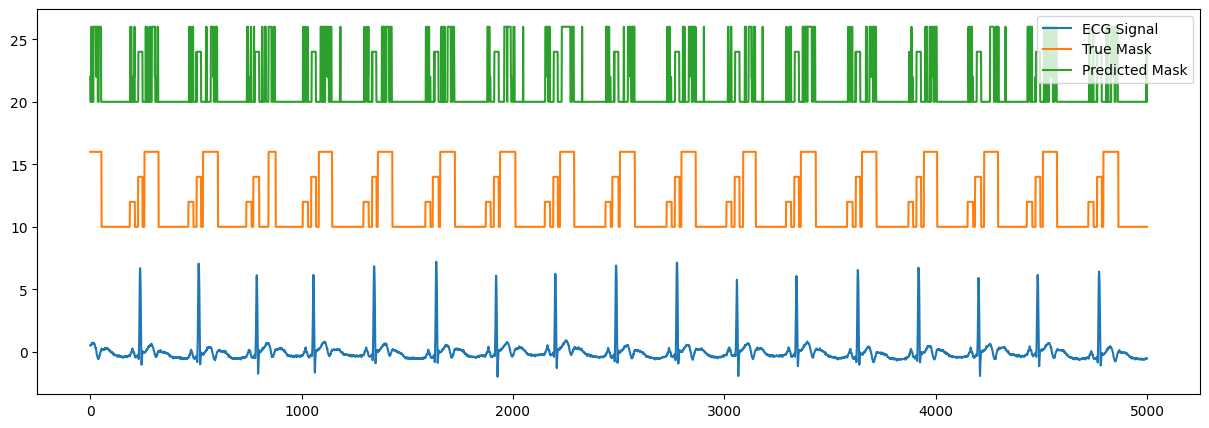

In [22]:
def plot_results(ecg_segment, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.plot(true_mask * 2+10, label='True Mask')
    plt.plot(predicted_mask * 2+20, label='Predicted Mask')
    plt.legend()
    plt.show()

# Make predictions on a test sample
sample_index = 1 #identifies which sample to test
sample_ecg = X_norm_test[sample_index]
sample_true_mask = y_norm_test[sample_index]
sample_predicted_mask = model_cnn.predict(sample_ecg.reshape(1, 5000, 1))[0]
sample_predicted_mask = np.argmax(sample_predicted_mask, axis=1)

plot_results(sample_ecg, sample_true_mask, sample_predicted_mask)

In [24]:
model_cnn2 = Sequential([
    Input(shape=(5000, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=4, kernel_size=3, activation='softmax', padding='same')
])

model_cnn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history2 = model_cnn2.fit(X_norm_train, y_norm_train_cat, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.6377 - loss: 0.9567 - val_accuracy: 0.6899 - val_loss: 0.8020
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7011 - loss: 0.7830 - val_accuracy: 0.7154 - val_loss: 0.7519
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7164 - loss: 0.7514 - val_accuracy: 0.7185 - val_loss: 0.7438
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7180 - loss: 0.7468 - val_accuracy: 0.7190 - val_loss: 0.7405
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7213 - loss: 0.7366 - val_accuracy: 0.7206 - val_loss: 0.7414
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7211 - loss: 0.7366 - val_accuracy: 0.7219 - val_loss: 0.7355
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7219 - loss: 0.7345 - val_accuracy: 0.7228 - val_loss: 0.7317
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.7246 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


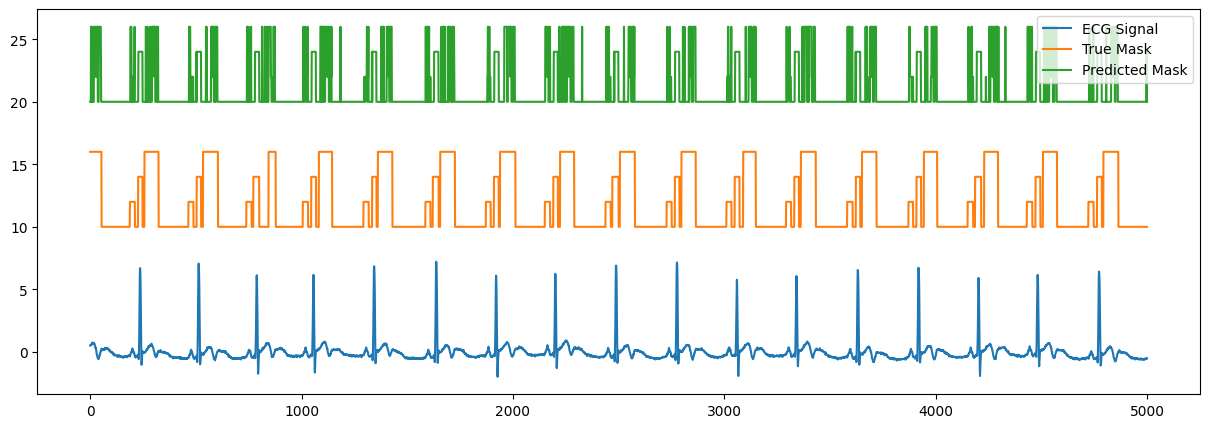

In [26]:
def plot_results(ecg_segment, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.plot(true_mask * 2+10, label='True Mask')
    plt.plot(predicted_mask * 2+20, label='Predicted Mask')
    plt.legend()
    plt.show()

# Make predictions on a test sample
sample_index = 1 #identifies which sample to test
sample_ecg = X_norm_test[sample_index]
sample_true_mask = y_norm_test[sample_index]
sample_predicted_mask = model_cnn2.predict(sample_ecg.reshape(1, 5000, 1))[0]
sample_predicted_mask = np.argmax(sample_predicted_mask, axis=1)

plot_results(sample_ecg, sample_true_mask, sample_predicted_mask)

In [ ]:
# 8. Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()